# Frequency analysis of probe locations

In [1]:
import torch as pt
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from utils import add_stl_patch, normalize_frequency, spatio_temporal_correlation, filter_time_series
from flow_conditions import U_INF, A_INF, CHORD

plt.rcParams['figure.dpi'] = 160
plt.rc('text', usetex=True)

output = "./output/naca0012_analysis/probes/"
!mkdir -p $output

## Mean and standard deviation of speed, probe locations, line sample

In [2]:
data = "./output/naca0012_data/slice/"
x = pt.load(data + "x_ref1_z25.pt")
y = pt.load(data + "y_ref1_z25.pt")
times = pt.load(data + "times_ref1_z25.pt")
n_points = x.shape[0]
U = pt.load(data + "dm_ref1_z25.pt")[:3*n_points, :]
U = (U[:n_points, :]**2 + U[n_points:2*n_points, :]**2 + U[2*n_points:3*n_points, :]**2).sqrt()

In [3]:
probes = pt.tensor(
    [
        [0.28, 0.1],
        [0.6, 0.08],
        [1.04, 0.02],
        [0.75, 0.5]
    ]
)

In [4]:
np_line = 21
line = pt.stack((
    pt.linspace(0.7, 0.8, np_line),
    pt.linspace(0.5, 0.5, np_line),
)).T

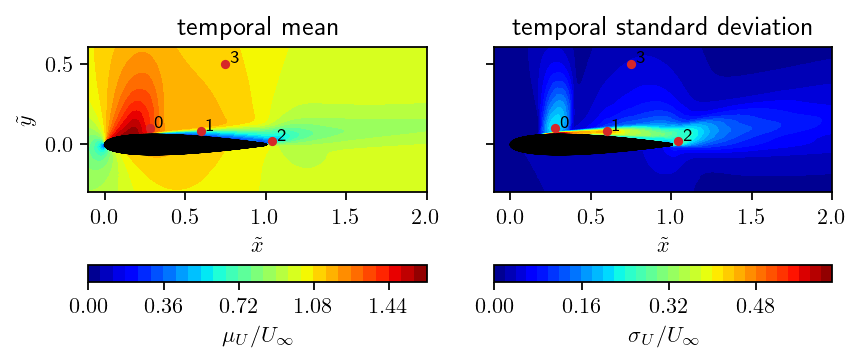

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)

every = 2
cont1 = ax1.tricontourf(x[::every], y[::every], U.mean(dim=1)[::every]/U_INF, cmap="jet", levels=30)
cont2 = ax2.tricontourf(x[::every], y[::every], U.std(dim=1)[::every]/U_INF, cmap="jet", levels=30)
cbar1 = plt.colorbar(cont1, ax=ax1, label=r"$\mu_U/U_\infty$", orientation="horizontal", pad=0.2)
cbar2 = plt.colorbar(cont2, ax=ax2, label=r"$\sigma_U/U_\infty$", orientation="horizontal", pad=0.2)
cbar1.ax.locator_params(nbins=5)
cbar2.ax.locator_params(nbins=5)
for ax in (ax1, ax2):
    ax.scatter(probes[:, 0], probes[:, 1], marker="o", c="C3", s=10, zorder=5)
    # ax.plot(line[:, 0], line[:, 1], ls="--", c="C3", lw=1)
    ax.set_xlabel(r"$\tilde{x}$")
    ax.set_aspect("equal")
    ax.set_xlim(-0.1, 2.0)
    ax.set_ylim(-0.3, 0.6)
    add_stl_patch(ax)
    for p in range(probes.shape[0]):
        ax.text(probes[p, 0]+0.03, probes[p, 1]+0.03, s=f"{p}", fontsize=8, c="k", va="center")
ax1.set_ylabel(r"$\tilde{y}$")
# ax1.text(line[0, 0], line[0, 1]+0.02, "line sample")
ax1.set_title("temporal mean")
ax2.set_title("temporal standard deviation")

plt.savefig(f"{output}U_mean_std.pdf", bbox_inches="tight")
plt.savefig(f"{output}U_mean_std.svg", bbox_inches="tight")
plt.savefig(f"{output}U_mean_std.png", bbox_inches="tight")
plt.show()

### Probes

In [6]:
Up = []
vertices = pt.stack((x, y), dim=1)
for pi in range(probes.shape[0]):
    closest = (vertices - probes[pi]).norm(dim=1).argmin()
    Up.append(U[closest])

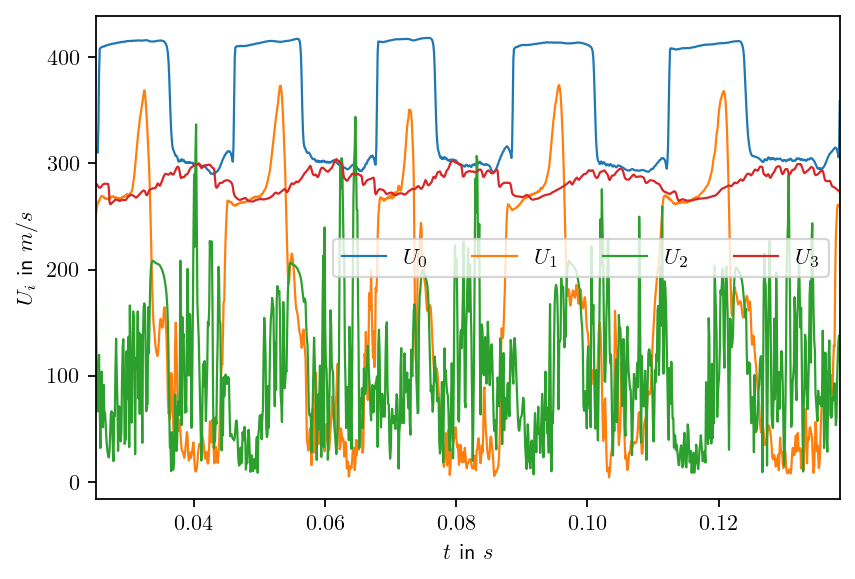

In [7]:
for i in range(len(Up)):
    plt.plot(times, Up[i], lw=1, label=r"$U_{:1d}$".format(i))

plt.xlabel(r"$t$ in $s$")
plt.ylabel(r"$U_{i}$ in $m/s$")
plt.legend(ncol=4)
plt.xlim(times[0], times[-1])
plt.show()

In [8]:
freq, amp = [], []
fs = 1.0 / (times[1] - times[0]).item()
for i, Upi in enumerate(Up):
    f, a = welch((Upi - Upi.mean()).numpy(), fs=fs, nperseg=int(len(Upi)*0.5), nfft=len(Upi))
    top = a.argsort()[-3:][::-1]
    print("Top 3 frequencies: ", normalize_frequency(f[top]))
    freq.append(normalize_frequency(pt.from_numpy(f)))
    amp.append(pt.from_numpy(a))
    pt.save(freq[-1], f"{output}f_p{i}.pt")
    pt.save(amp[-1], f"{output}a_p{i}.pt")

Top 3 frequencies:  [0.65128065 0.78153678 0.52102452]
Top 3 frequencies:  [0.65128065 0.78153678 0.52102452]
Top 3 frequencies:  [1.3025613  0.65128065 1.17230517]
Top 3 frequencies:  [0.65128065 0.78153678 0.52102452]


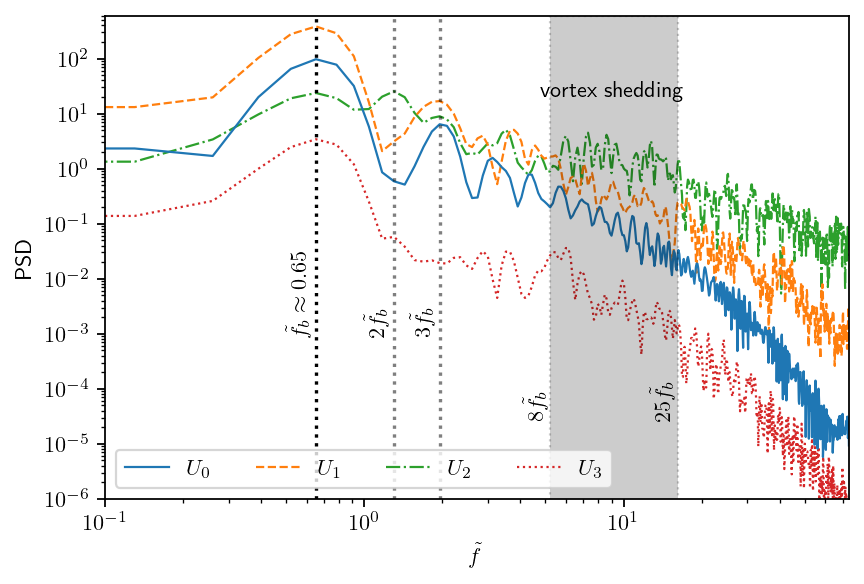

In [9]:
ls = ("-", "--", "-.", ":")

fb = 0.6512
plt.fill_between([8*fb, 25*fb], [600, 600], color="k", ls=":", alpha=0.2)
for i in range(len(Up)):
    plt.plot(freq[i], amp[i], ls=ls[i], lw=1, label=r"$U_{:d}$".format(i), zorder=-i)
    
plt.xlabel(r"$\tilde{f}$")
plt.ylabel("PSD")
plt.xlim(0.1, freq[0][-1])
plt.ylim(1e-6, 600)
plt.xscale("log")
plt.yscale("log")
plt.legend(ncol=4)
plt.axvline(0.6512, ls=":", c="k")
plt.text(0.5, 10e-4, r"$\tilde{f}_b\approx 0.65$", rotation=90)
plt.axvline(0.6512*2, ls=":", c="k", alpha=0.5)
plt.text(0.5*2, 10e-4, r"$2\tilde{f}_b$", rotation=90)
plt.axvline(0.6512*3, ls=":", c="k", alpha=0.5)
plt.text(0.5*3, 10e-4, r"$3\tilde{f}_b$", rotation=90)
plt.text(4.1, 3e-5, r"${:2.0f}\tilde{{f}}_b$".format(8), rotation=90)
plt.text(12.6, 3e-5, r"${:2.0f}\tilde{{f}}_b$".format(25), rotation=90)
plt.text(9, 20, "vortex shedding", ha="center")

plt.savefig(f"{output}probe_spectra.pdf", bbox_inches="tight")
plt.savefig(f"{output}probe_spectra.svg", bbox_inches="tight")
plt.savefig(f"{output}probe_spectra.png", bbox_inches="tight")
plt.show()

### Spatio-temporal Correlation along sample line

In [10]:
Ul = []
for pi in range(line.shape[0]):
    closest = (vertices - line[pi]).norm(dim=1).argmin()
    Ul.append(U[closest])
Ul = pt.stack(Ul, dim=1).T

In [11]:
Ul_prime = Ul - Ul.mean(dim=1).unsqueeze(-1)

In [12]:
dx_i = line[1, 0] - line[0, 0]
dt_i = times[1] - times[0]
dx = line[-1, 0] - line[0, 0]
dt = times[-1] - times[0]

In [13]:
Ul_prime_filtered = filter_time_series(Ul_prime, 1.0/dt_i.item(), 700)

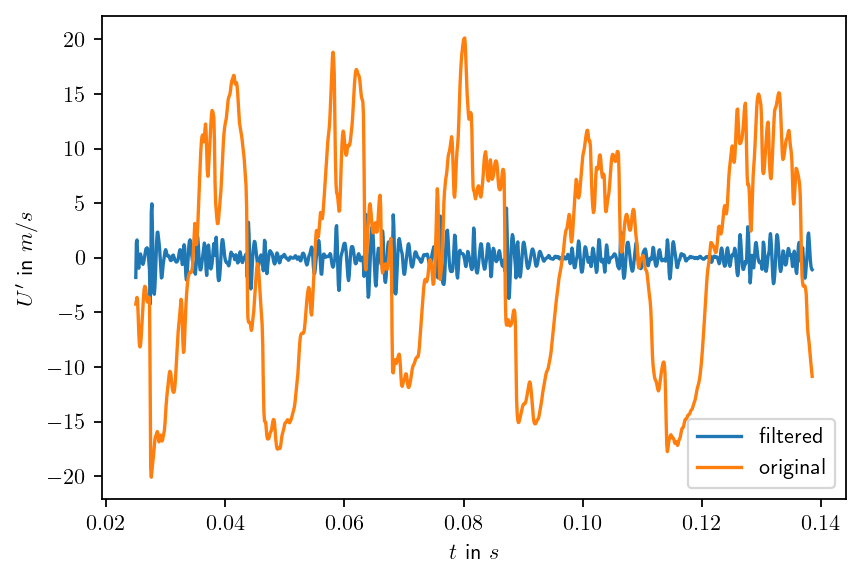

In [14]:
plt.plot(times, Ul_prime_filtered[0, :], label="filtered")
plt.plot(times, Ul_prime[0, :], label="original")
plt.legend()
plt.xlabel(r"$t$ in $s$")
plt.ylabel(r"$U^\prime$ in $m/s$")
plt.show()

In [22]:
n_tau = 50
tau = pt.arange(-n_tau*dt_i, (n_tau+0.1)*dt_i, dt_i) * U_INF / CHORD
dd, tt = pt.meshgrid(line[:, 0], tau)

In [23]:
R_test = spatio_temporal_correlation(Ul_prime_filtered, n_tau)

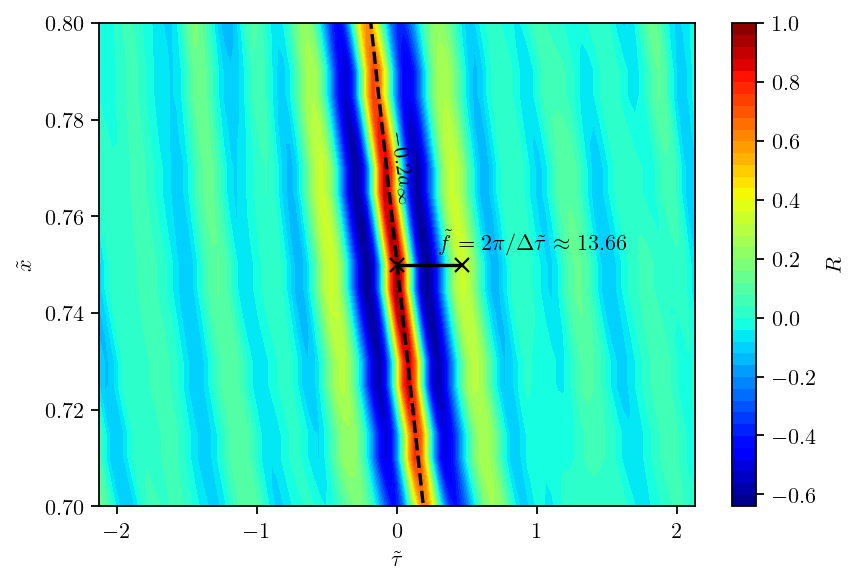

In [24]:
cf = plt.contourf(tt, dd, R_test, levels=50, cmap="jet")
plt.colorbar(cf, label=r"$R$")
slope = -0.2*A_INF / U_INF
plt.plot(tau, tau*slope+0.75, ls="--", c="k")
plt.text(-0.075, 0.77, r"$-0.2a_\infty$", rotation=-81, va="center")
plt.plot([0.0, 0.46], [0.75, 0.75], c="k", marker="x")
plt.text(0.3, 0.753, r"$\tilde{{f}} = 2\pi/\Delta \tilde{{\tau}} \approx {:2.2f}$".format(1.0/(0.46 - 0.0)*2.0*np.pi))
plt.ylim(0.7, 0.8)
plt.ylabel(r"$\tilde{x}$")
plt.xlabel(r"$\tilde{\tau}$")
plt.show()

In [25]:
from scipy.signal import correlate, correlation_lags

corr_mat = pt.zeros_like(Ul_prime)
for i in range(Ul_prime.shape[0]):
    corr_mat[i] = pt.from_numpy(correlate(Ul_prime_filtered[i], Ul_prime_filtered[10], mode="same", method="direct"))

In [26]:
tau_c = correlation_lags(Ul_prime[0].shape[0], Ul_prime[0].shape[0], mode="same") * dt_i.item()* U_INF / CHORD
ddc, ttc = pt.meshgrid(line[:, 0], pt.from_numpy(tau_c).type(pt.float32))

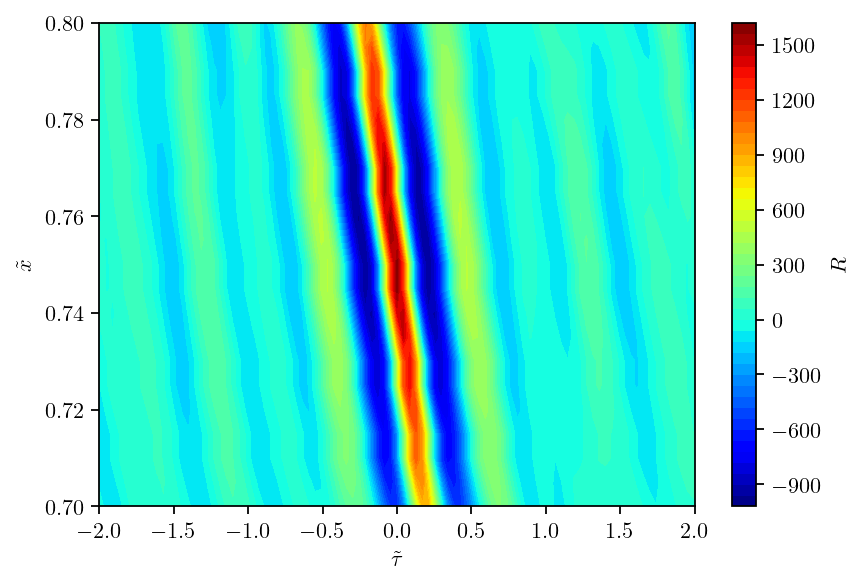

In [27]:
cf = plt.contourf(ttc, ddc, corr_mat, levels=50, cmap="jet")
plt.colorbar(cf, label=r"$R$")
plt.xlim(-2, 2)
plt.ylabel(r"$\tilde{x}$")
plt.xlabel(r"$\tilde{\tau}$")
plt.show()

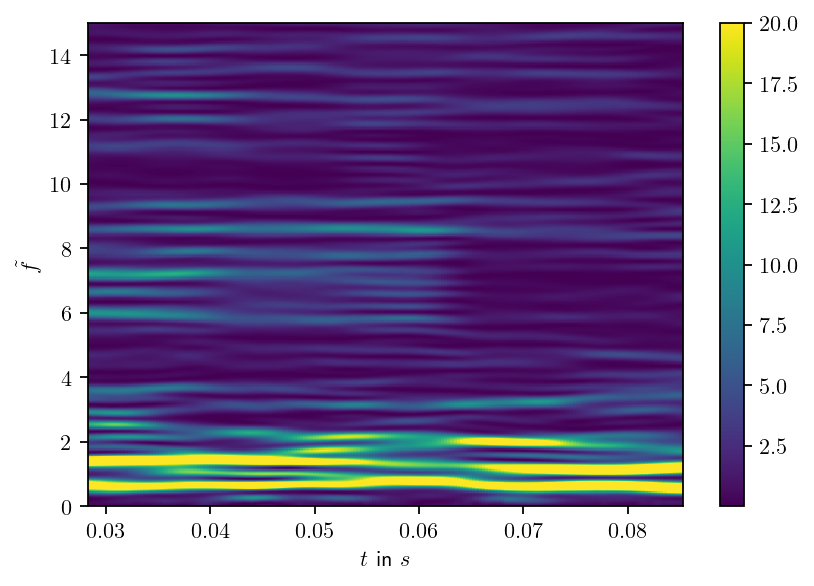

In [28]:
from scipy.signal import spectrogram

f, t, Sxx = spectrogram(Up[2].numpy(), 1.0/dt_i.item(), nperseg=int(times.shape[0]/2), noverlap=int(times.shape[0]/2.01), nfft=times.shape[0]*4)

#pcol = plt.pcolormesh(t, normalize_frequency(f), np.log(np.where(Sxx > 0.01, Sxx, 0.01)), shading='auto')
pcol = plt.pcolormesh(t, normalize_frequency(f), Sxx, shading='auto', vmax=20)
plt.colorbar(pcol)
plt.ylabel(r"$\tilde{f}$")
plt.xlabel(r"$t$ in $s$")
plt.ylim(0, 15)
plt.show()